In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8829874231919889264,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4949437312
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11336632949792778470
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [2]:
import tensorflow as tf
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [3]:
x = tf.random.uniform([3, 3])
print(x.device.endswith('GPU:0'))

True


In [4]:
import collections
import gym
import numpy as np
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers

env = gym.make("CartPole-v0")

seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

eps = np.finfo(np.float32).eps.item()

In [4]:
import os
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [8]:
observe = env.reset()
state, reward, done, _ = env.step(0)
print('Observe')
print('Cart Position: {}, Cart Velocity: {}'.format(round(observe[0],4), round(observe[1],4)))
print('Stick Angle: {}, Stick Turnover Ratio: {}'.format(round(observe[2],4), round(observe[3],4)))
print('State')
print('Cart Position: {}, Cart Velocity: {}'.format(round(state[0],4), round(state[1],4)))
print('Stick Angle: {}, Stick Turnover Ratio: {}'.format(round(state[2],4), round(state[3],4)))
print('Reward: {}, Done: {}'.format(reward, done))

Observe
Cart Position: -0.0126, Cart Velocity: -0.0016
Stick Angle: 0.0421, Stick Turnover Ratio: -0.0018
State
Cart Position: -0.0126, Cart Velocity: -0.1973
Stick Angle: 0.042, Stick Turnover Ratio: 0.3039
Reward: 1.0, Done: False


In [34]:
box_x, box_y, box_z = 20,20,20
state = []
action_space = []
for i in range(box_x):
    state.append([])
    for j in range(box_y):
        state[i].append([])
        for k in range(box_z):
            state[i][j].append(0)
            action_space.append([i,j,k])
state[0][4][2] = 1
state = np.array(state)
state = state.reshape(-1, 1)
np.sum(state), state.shape

(1, (8000, 1))

In [18]:
class Env:
    def __init__(self, box_x, box_y, box_z):
        self.box_x, self.box_y, self.box_z = box_x, box_y, box_z
        self.state = []
        self.action_space = []
        for i in range(box_x):
            self.state.append([])
            for j in range(box_y):
                self.state[i].append([])
                for k in range(box_z):
                    self.state[i][j].append(0)
                    self.action_space.append([i,j,k])
        
    def step(self, box, action):
        size, pos = box
        
        
        reward = sum(self.state) / 8000
        return self.state, reward, done
    
    def masking(self, box):
        size, pos = box
        
        possible_action_space = []
        
        possible_x = []
        possible_y = []
        possible_z = []
        
        possible_action_space = [possible_x, possible_y, possible_z]
        
        return possible_action_space
    
    def reset(self):
        for i in range(len(self.state)):
            for j in range(len(self.state[i])):
                for k in range(len(self.state[i][j])):
                    self.state[i][j][k] = True
        
        return self.state

In [19]:
env = Env(20,20,20)

In [5]:
class ActorCritic(tf.keras.Model):
    def __init__(self, num_actions, num_hidden_units):
        super().__init__()
        self.common = layers.Dense(num_hidden_units, activation="relu")
        self.actor = layers.Dense(num_actions)
        self.critic = layers.Dense(1)
        
    def call(self, inputs):
        x = self.common(inputs)
        return self.actor(x), self.critic(x)

In [6]:
num_actions = env.action_space.n  # 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

In [7]:
def env_step(action):
    state, reward, done, _ = env.step(action)
    return (state.astype(np.float32), np.array(reward, np.int32), 
            np.array(done, np.int32))

def tf_env_step(action):
    return tf.numpy_function(env_step, [action], [tf.float32, tf.int32, tf.int32])

In [8]:
def run_episode(initial_state, model, max_steps):
    action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
    
    initial_state_shape = initial_state.shape
    state = initial_state
    
    for t in range(max_steps):
        state = tf.expand_dims(state, 0)
        action_logits_t, value = model(state)
        
        action = tf.random.categorical(action_logits_t, 1)[0, 0]
        action_probs_t = tf.nn.softmax(action_logits_t)

        values = values.write(t, tf.squeeze(value))
        action_probs = action_probs.write(t, action_probs_t[0, action])
        
        state, reward, done = tf_env_step(action)
        
        state.set_shape(initial_state_shape)
        rewards = rewards.write(t, reward)
        
        if done.numpy() == 1:
            break
            
    action_probs = action_probs.stack()
    values = values.stack()
    rewards = rewards.stack()

    return action_probs, values, rewards

In [9]:
def get_expected_return(rewards, gamma, standardize = True):
    n = tf.shape(rewards)[0]
    returns = tf.TensorArray(dtype=tf.float32, size=n)
    
    rewards = tf.cast(rewards[::-1], dtype=tf.float32)
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape
    
    for i in tf.range(n):
        reward = rewards[i]
        discounted_sum = reward + gamma * discounted_sum
        discounted_sum.set_shape(discounted_sum_shape)
        returns = returns.write(i, discounted_sum)
    returns = returns.stack()[::-1]
    
    if standardize:
        returns = ((returns - tf.math.reduce_mean(returns)) /
                   (tf.math.reduce_std(returns) + eps))

    return returns

In [10]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(action_probs, values, returns):
    advantage = returns - values
    action_log_probs = tf.math.log(action_probs)
    
    actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)
    critic_loss = huber_loss(values, returns)

    return actor_loss + critic_loss

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

def train_step(initial_state, model, optimizer, gamma, max_steps_per_episode):
    with tf.GradientTape() as tape:
        action_probs, values, rewards = run_episode(initial_state, model, max_steps_per_episode)
        returns = get_expected_return(rewards, gamma)
        
        action_probs, values, returns = [tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 
        
        loss = compute_loss(action_probs, values, returns)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    episode_reward = tf.math.reduce_sum(rewards)

    return episode_reward

In [36]:
config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

In [12]:
%%time

max_episodes = 10000
max_steps_per_episode = 1000

reward_threshold = 195
running_reward = 0

gamma = 0.99
with tqdm.trange(max_episodes) as t:
    for i in t:
        initial_state = tf.constant(env.reset(), dtype=tf.float32)
        episode_reward = int(train_step(initial_state, model, optimizer, gamma, max_steps_per_episode))

        running_reward = episode_reward*0.01 + running_reward*.99

        t.set_description(f'Episode {i}')
        t.set_postfix(episode_reward=episode_reward, running_reward=running_reward)

        if i % 10 == 0:
            pass

        if running_reward > reward_threshold:  
            break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

Episode 5035:  50%|███████████▌           | 5035/10000 [57:00<56:13,  1.47it/s, episode_reward=200, running_reward=195]


Solved at episode 5035: average reward: 195.02!
Wall time: 57min


In [13]:
%%time

max_episodes = 10000
max_steps_per_episode = 1000

reward_threshold = 195
running_reward = 0

gamma = 0.99
with tqdm.trange(max_episodes) as t:
    for i in t:
        initial_state = tf.constant(env.reset(), dtype=tf.float32)
        episode_reward = int(train_step(initial_state, model, optimizer, gamma, max_steps_per_episode))

        running_reward = episode_reward*0.01 + running_reward*.99

        t.set_description(f'Episode {i}')
        t.set_postfix(episode_reward=episode_reward, running_reward=running_reward)

        if i % 10 == 0:
            pass

        if running_reward > reward_threshold:  
            break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

Episode 5:   0%|                          | 6/10000 [00:05<2:43:00,  1.02it/s, episode_reward=200, running_reward=11.7]


KeyboardInterrupt: 

In [10]:
from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display

In [21]:
def render_episode(env, model, max_steps): 
    screen = env.render(mode='rgb_array')
    im = Image.fromarray(screen)

    images = [im]
    
    state = tf.constant(env.reset(), dtype=tf.float32)
    for i in range(1, max_steps + 1):
        state = tf.expand_dims(state, 0)
        action_probs, _ = model(state)
        action = np.argmax(np.squeeze(action_probs))

        state, _, done, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)

        if i % 10 == 0:
            screen = env.render(mode='rgb_array')
            images.append(Image.fromarray(screen))
            
        if done:
            break
    return images

In [22]:
images = render_episode(env, model, max_steps_per_episode)
image_file = 'cartpole-v0.gif'

images[0].save(image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


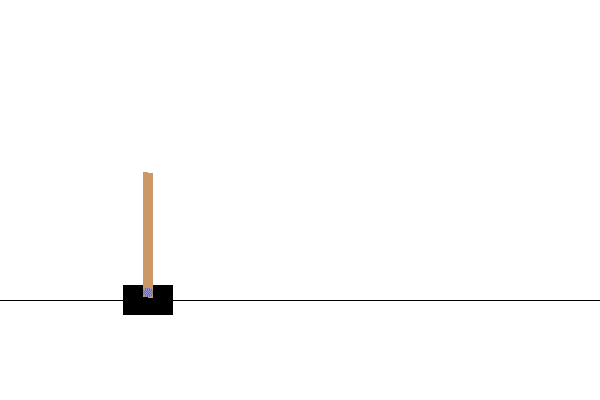

In [23]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)